# Identification
Please indicate your name and parcours (e.g.: IMA, DIGIT, BIM, DAC, ..., Erasmus)

Student 1: Erisa Kohansal, ANDROIDE

Student 2: Sama Satariyan, ANDROIDE

# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercise 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [2]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    Sx = np.outer(np.array([1, 2, 1]).T, [1, 0, -1])
    Sy = Sx.T
    Ix = convolve2d(I, Sx, boundary='symm', mode='same') # convolve2d(I, Sx) != convolve2d(Sx, I)
    Iy = convolve2d(I, Sy, boundary='symm', mode='same')
    Ig = np.sqrt(Ix*Ix + Iy*Iy)
    return np.where(Ig <= s, 0, 255)

def SobelElements(I):
    """ Array -> Array*Array*Array"""
    Sx = np.outer(np.array([1, 2, 1]).T, [1, 0, -1])
    Sy = Sx.T
    Ix = convolve2d(I, Sx, boundary='symm', mode='same') 
    Iy = convolve2d(I, Sy, boundary='symm', mode='same')
    Ig = np.sqrt(Ix*Ix + Iy*Iy)
    return Ix, Iy, Ig

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [3]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    L = np.array([[0,1,0],
                  [1,-4,1],
                  [0,1,0]])
    IL = convolve2d(I, L, boundary='symm', mode='same')
    n, m = IL.shape
    zero_crossing = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            # neighbourhood of 3x3 
            IL_neigh = IL[i:i+3, j:j+3]
            zero_crossing[i, j] = 255 * (np.max(IL_neigh) > 0 and np.min(IL_neigh) < 0 and np.max(IL_neigh) - np.min(IL_neigh) > s)
    return zero_crossing

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

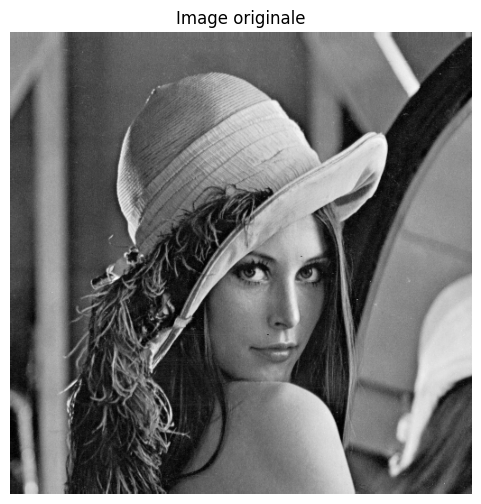

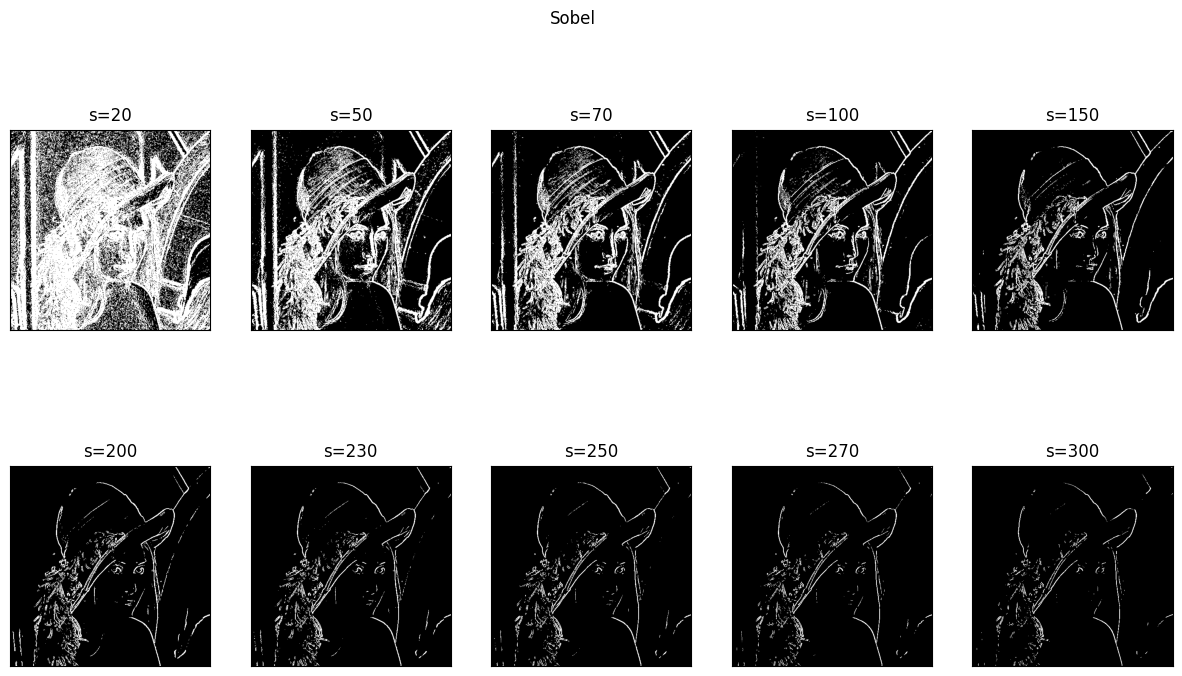

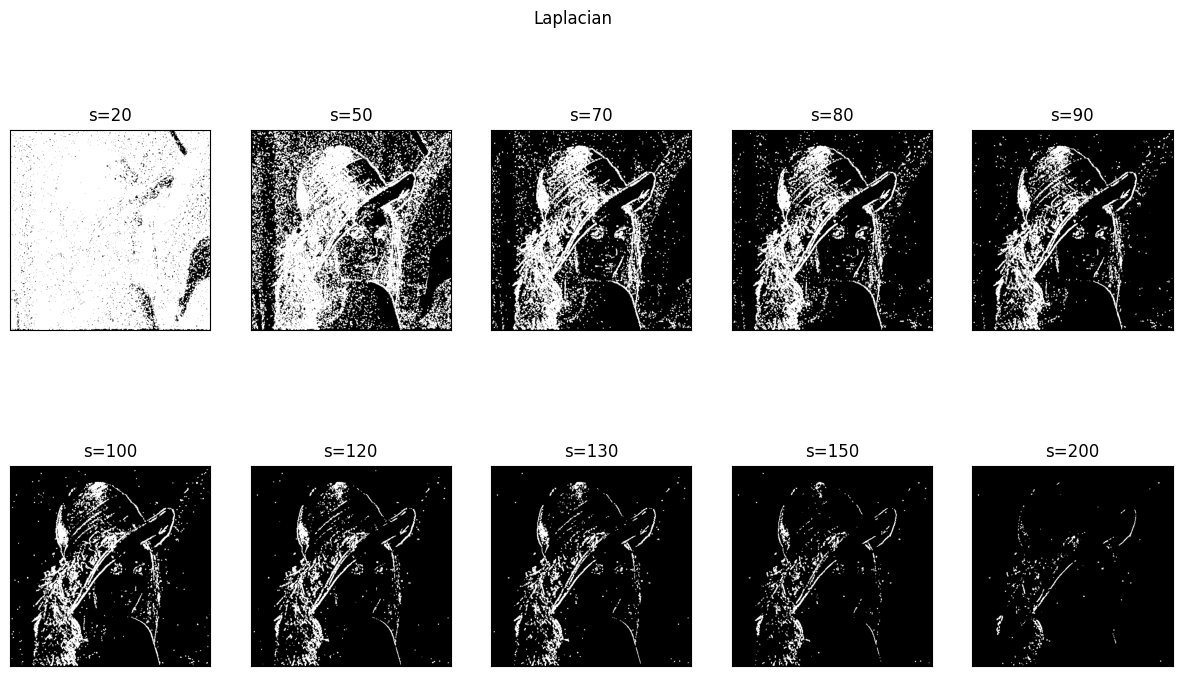

In [4]:
lena = np.array(Image.open("img/lena.png"))
imshow(lena, "Image originale")
sobel_seuil = [20, 50, 70, 100, 150, 200, 230, 250, 270, 300]
laplacian_seuil = [20, 50, 70, 80, 90, 100, 120, 130, 150, 200]
for mode, (func, seuil) in {"Sobel":(SobelDetector, sobel_seuil), "Laplacian":(LaplacianDetector, laplacian_seuil)}.items():
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
    fig.suptitle(mode)
    elems = 0
    for s in seuil:
        tmp = func(lena, s)
        i, j = elems//5, elems-5 if elems >= 5 else elems
        ax[i, j].imshow(tmp, cmap="gray")
        ax[i, j].set_title(f"s={s}")
        ax[i, j].set_xticks(())
        ax[i, j].set_yticks(())
        elems += 1
    plt.show()

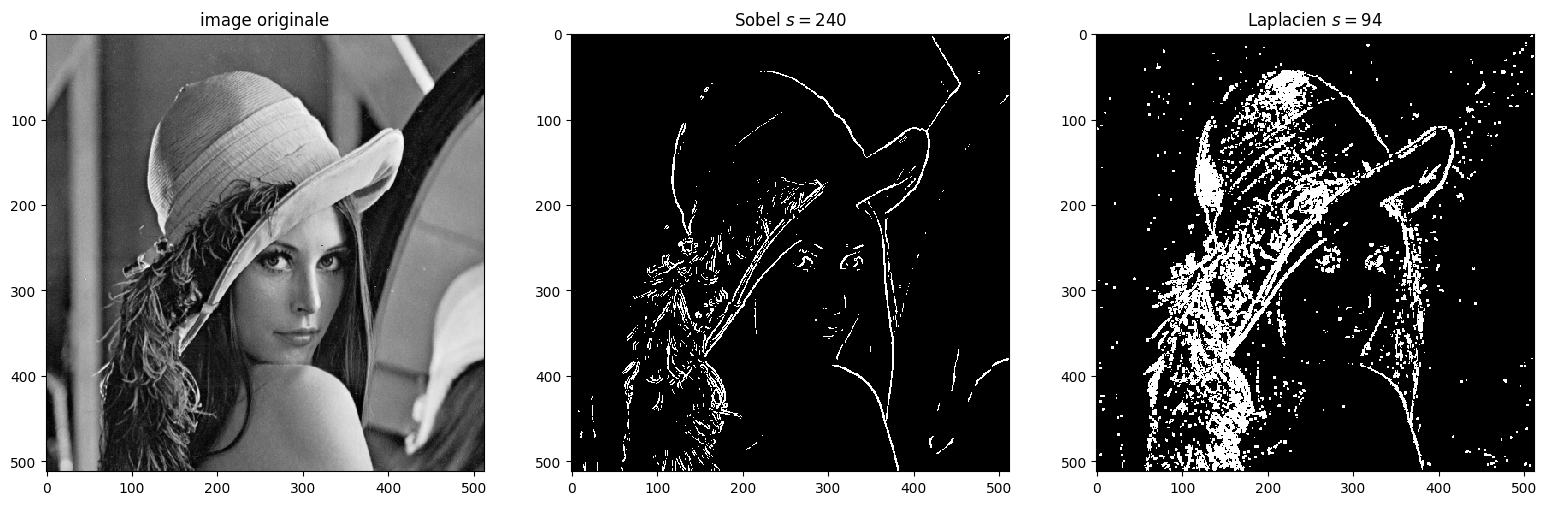

In [5]:
niceDisplay14([lena, SobelDetector(lena, 240), LaplacianDetector(lena, 94)], ["image originale", "Sobel $s=240$", "Laplacien $s=94$"])

Les détecteurs de contours basé sur la dérivée de l'image font partie des filtres highpass, ils sont donc plus sensibles au bruit. Chaque filtre qui implémente une dérivée ne doit donc pas répondre à une valeur constante (=si l'intensité des pixels est la même partout, le filtre doit retourner une valeur nulle, car il n'y a pas de variation à détecter), cela signifie que la somme de ses coefficients doit toujours être égale à zéro. 
Le Laplacien et le Sobel sont des opérateurs de gradient discrets. Ils sont utilisés comme filtres d'approximation des dérivées pour estimer le gradient dans une image.

La sélectionne de la valeur $s$ du Threshold est un compromis entre capturer tous les vrais bords de l'image et éliminer le bruit:
- Si $s$ augmente, on réduit l'impact du bruit mais on risque de perdre les bords les plus faibles, ce qui rend les bords plus irrégulier.
- Si on diminue $s$, on obtient des contours de bords plus complets, mais on est également plus sensible au bruit, ce qui peux ajouter des faux bords.

En résumé, en augmentant $s$ les bords deviennent plus fins et en le diminuant, ils s'élargissent.

Sobel:
- Un détecteur de premier ordre, c'est-à-dire qu'il détecte les bords en calculant les dérivées premières dans les directions $x$ et $y$.
- Pour des seuils faibles, beaucoup de bruit est détecté mais aussi des détails plus faibles de l'image.
- Pour un seuil plus élevé, seuls les bords les plus nets et les plus forts sont conservés. A partir de $s=150$, on observe que les contours principaux de l'image sont bien définis mais certains détails plus faibles sont perdus.
- D'après les tests, Sobel donne généralement des contours plus lisses.

Laplacian:
- Un détecteur de seconde ordre, qui utilise la dérivée seconde pour détecter les bords.
- Pour des seuils faibles, on observe beaucoup de bruit et l'image est moins claire.
- Pour un seuil plus élevé, les contours deviennet plus propre.
- D'après les tests, Laplacian détecte les bords avec plus de précision, mais il est plus sensible au bruit et peut produire des résultats plus fragmentés.

On remarque que le détecteur de Sobel donne toujours de meilleurs résultats. Le Laplacien, même avec un seuil plus bas, a du mal à bien distinguer certains détails comme les lèvres et le nez de Lena. De plus, il génère généralement plus de bruit.
Dans les deux cas, en augmantant la valeur du seuil, la sensibilité du filtre diminue. Cela veut dire qu'on détecte de moins en moins de contours sur l'image.

Les deux détecteurs trouvent approximativement les mêmes contours pour un seuil égal à $70$, ou même pour Sobel $=240$ et Laplacian $=94$.

## Exercise 2: non maximum suppression

This exercise addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the notebook to see pixels value pointed by the mouse screen. **Warning**, this mode works only with jupyter notebook up to version 6).

[0. 1. 2. 3. 4.]


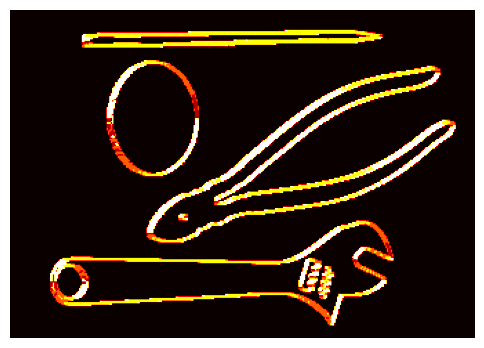

In [6]:
%matplotlib inline
# !pip3 install notebook=6 (if necessary)

#### your answer below
tools = np.array(Image.open('img/tools.png'))
Ior_tools = orientation(*SobelElements(tools))
print(np.unique(Ior_tools))
imshow_hot(Ior_tools)

Explain the different values given to a pixel by `orientation()`:

Comme indiqué dans l'énoncé(et vérifié par la fonction np.unique), la matrice retournée par la fonction ```orientation()``` a $5$ valeurs différentes allant de $0$ à $4$. Ces valeurs expriment l'orientation du gradient pour chaque pixel:
- $0$ : aucun contour n'est détecté car la mgnitude du gradient est nulle. Cela se produit dans les régions où l'intensité de l'image est uniforme.
- $1$ : contour avec un angle $\theta = 0$, (cf. TD : $A=d_1=(0, 1)$), la direction du gradient est horizontale, le contour est alors vertical.
- $2$ : contour avec un angle $\theta = \frac{\pi}{4}$, ($B=d_2=(\frac{\sqrt{2}}{2}, \frac{\sqrt{2}}{2})$), le gradient est à $45^\circ$ donc le contour suit une diagonale inclinée à $135^\circ$.
- $3$ : contour avec un angle $\theta = \frac{\pi}{2}$, ($C=d_3=(1,0)$), un contour horizontal.
- $4$ : contour avec un angle $\theta = \frac{3\pi}{4}$, ($D=d_4=(\frac{-\sqrt{2}}{2}, \frac{\sqrt{2}}{2})$), le diagonal est à $135^\circ$ donc le contour suit une diagonale inclinée à $45^\circ$.

Remarque : la direction de gradient est perpendiculaire à la direction du contour détecté.

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [7]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    n, m = Ig.shape
    G = np.zeros((n,m))
    for i in range(1, n-1):
        for j in range(1, m-1):
            cond = (Ior[i,j] == 1 and Ig[i,j] > max(Ig[i,j-1], Ig[i,j+1])) or \
                (Ior[i,j] == 2 and Ig[i,j] > max(Ig[i+1,j+1], Ig[i-1,j-1])) or \
                (Ior[i,j] == 3 and Ig[i,j] > max(Ig[i+1,j], Ig[i-1,j])) or \
                (Ior[i,j] == 4 and Ig[i,j] > max(Ig[i-1,j+1], Ig[i+1,j-1]))
            if cond : 
                G[i,j] = Ig[i,j]
    return G

Le gradient est un vector ayant une magnitude et une direction : 
- Sa magnitude mesures la variation maximale de l'intensité d'un pixel.
- Sa direction représente l'orientation de cette variation, elle pointe vers la direction dans laquelle l'intensité de l'image change le plus vite.

Le gradient est rarement constant le long d'un bord, càd la variation de l'intensité (=le gradient) ne reste pas uniforme le long d'un même bord (par exemple le contour d'un objet).

La suppression des non maxima consiste à supprimer tout point qui n'est pas un maximum local de la magnitude de gradient. Elle vise à affiner les contours détectés en ne conservant que les points où le gradient est maximal dans sa direction. Cela transforme les contours épais ou flous en lignes fines et précises d'une épaisseur d'un pixel. En examinant la direction du gradient, on effectue une recherche perpendiculaire au contour lui-même.

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


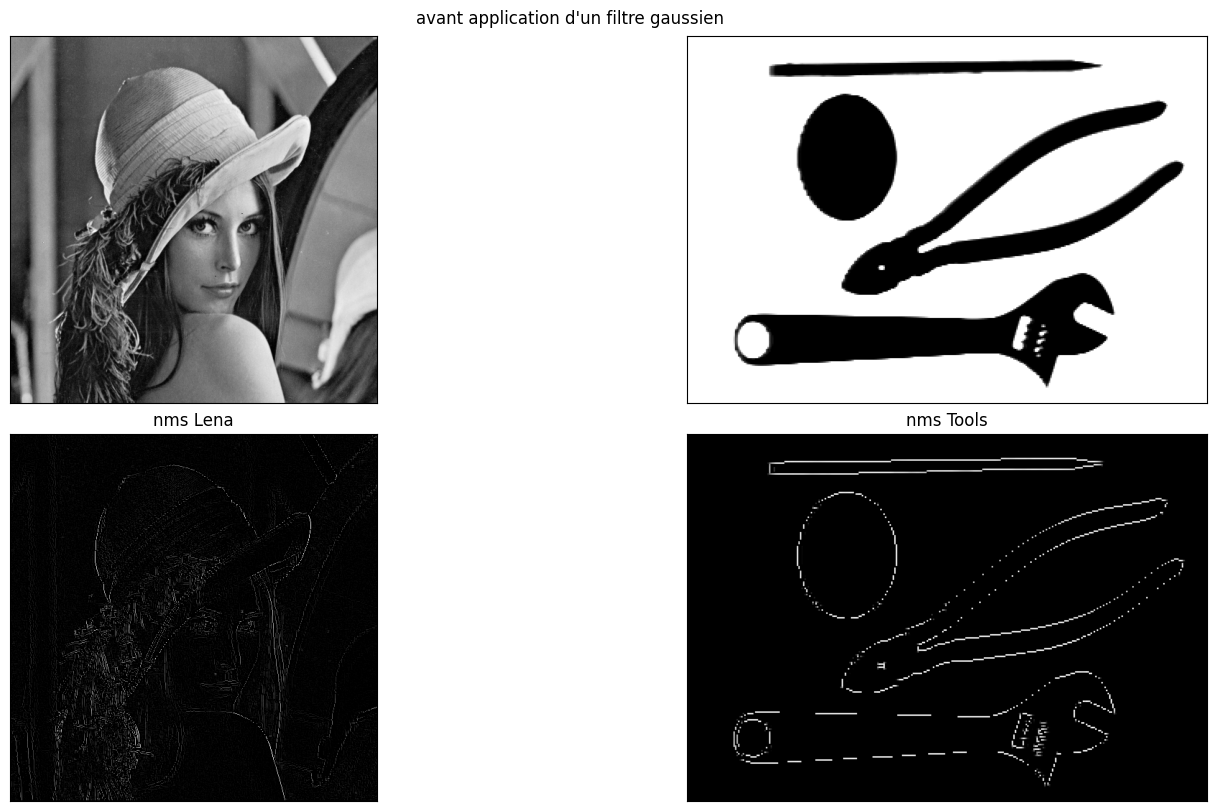

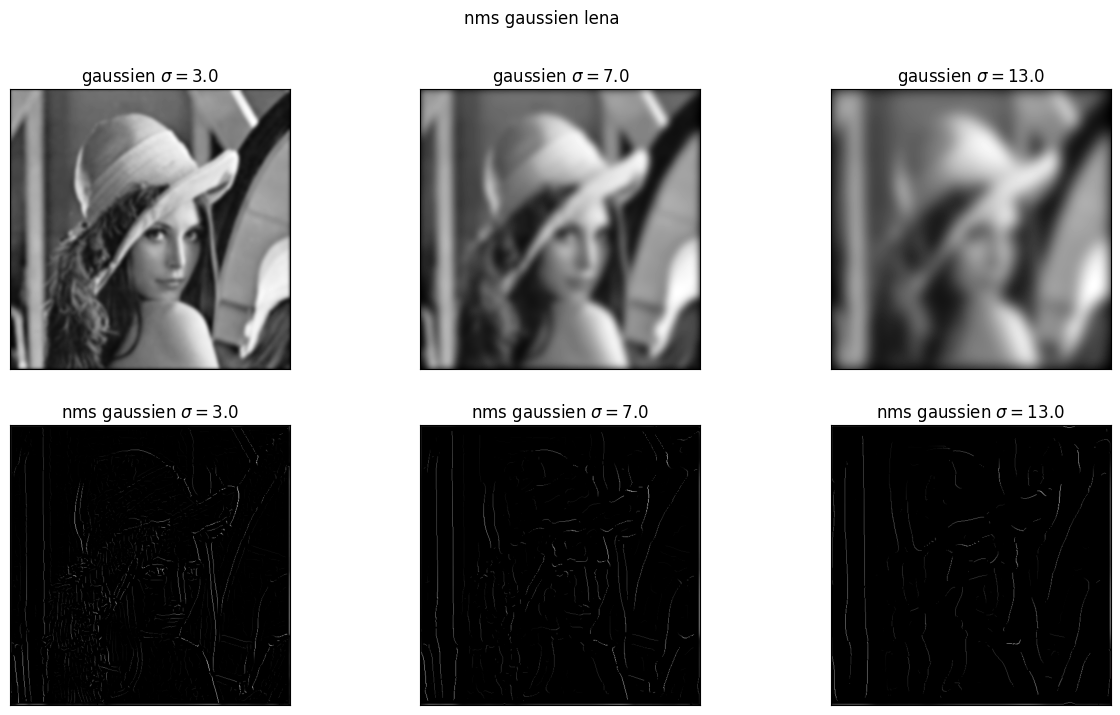

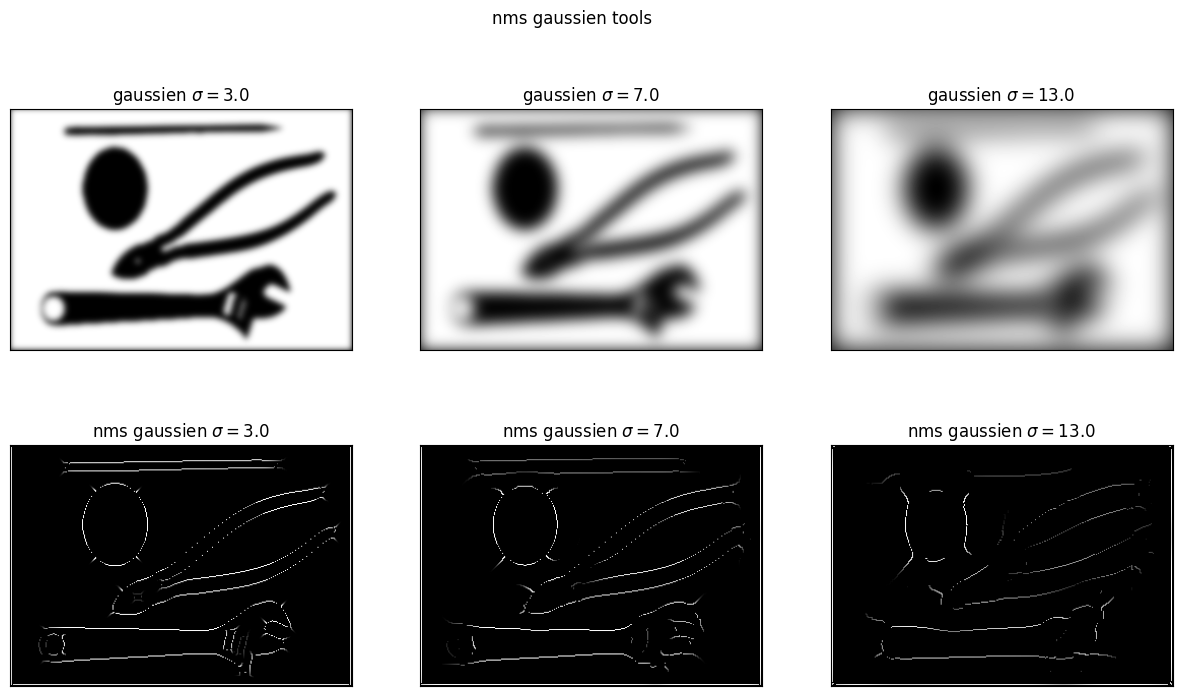

In [8]:
%matplotlib inline
### your answer below

# before gaussian filter
fig = plt.figure(figsize=(15, 8), constrained_layout=1)
fig.suptitle("avant application d'un filtre gaussien")
sub1 = plt.subplot(2, 2, 1)
sub1.imshow(lena, cmap="gray")
sub1.set_xticks(())
sub1.set_yticks(())

sub2 = plt.subplot(2, 2, 2)
sub2.imshow(tools, cmap="gray")
sub2.set_xticks(())
sub2.set_yticks(())

sub3 = plt.subplot(2, 2, 3)
Ix_lena, Iy_lena, Ig_lena = SobelElements(lena)
Ior_lena = orientation(Ix_lena, Iy_lena, Ig_lena)
sub3.imshow(nms(Ig_lena, Ior_lena), cmap="gray")
sub3.set_title("nms Lena")
sub3.set_xticks(())
sub3.set_yticks(())

sub4 = plt.subplot(2, 2, 4)
Ix_tools, Iy_tools, Ig_tools = SobelElements(tools)
Ior_tools = orientation(Ix_tools, Iy_tools, Ig_tools)
sub4.imshow(nms(Ig_tools, Ior_tools), cmap="gray")
sub4.set_title("nms Tools")
sub4.set_xticks(())
sub4.set_yticks(())
plt.show()

# after gaussian filter
fig1, ax1 = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
fig1.suptitle("nms gaussien lena")
fig2, ax2 = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
fig2.suptitle("nms gaussien tools")
cmp = 0
for sigma in [3, 7, 13]:
    gauss = gaussianKernel(sigma)
    gauss_lena = convolve2d(lena, gauss, mode='same')
    Ix_gauss_lena, Iy_gauss_lena, Ig_gauss_lena = SobelElements(gauss_lena)
    Ior_gauss_lena = orientation(Ix_gauss_lena, Iy_gauss_lena, Ig_gauss_lena)
    ax1[0, cmp].imshow(gauss_lena, cmap="gray")
    ax1[0, cmp].set_title("gaussien $\sigma=${:.1f}".format(sigma))
    ax1[0, cmp].set_xticks(())
    ax1[0, cmp].set_yticks(())
    ax1[1, cmp].imshow(nms(Ig_gauss_lena, Ior_gauss_lena), cmap="gray")
    ax1[1, cmp].set_title("nms gaussien $\sigma=${:.1f}".format(sigma))
    ax1[1, cmp].set_xticks(())
    ax1[1, cmp].set_yticks(())


    gauss_tools = convolve2d(tools, gauss, mode='same')
    Ix_gauss_tools, Iy_gauss_tools, Ig_gauss_tools = SobelElements(gauss_tools)
    Ior_gauss_tools = orientation(Ix_gauss_tools, Iy_gauss_tools, Ig_gauss_tools)
    ax2[0, cmp].imshow(gauss_tools, cmap="gray")
    ax2[0, cmp].set_title("gaussien $\sigma=${:.1f}".format(sigma))
    ax2[0, cmp].set_xticks(())
    ax2[0, cmp].set_yticks(())
    ax2[1, cmp].imshow(nms(Ig_gauss_tools, Ior_gauss_tools), cmap="gray")
    ax2[1, cmp].set_title("nms gaussien $\sigma=${:.1f}".format(sigma))
    ax2[1, cmp].set_xticks(())
    ax2[1, cmp].set_yticks(())

    cmp += 1
plt.show()


4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

Comme on a dit auparavant, les détecteurs de contours basé sur la dérivée de l'image font partie des filtres highpass, ils sont donc plus sensibles au bruit. Donc il est utile de lisser l'image avant de calculer le gradient. Le lissage d'une image avec un filtre gaussien réduit le bruit et nous évite de détecter des contours indésirables. 

- Avec une petite valeur de $\sigma$ on arrive à détecter presque tous les contours.
- En augmentant la valeur de $\sigma$ les contours moins nets disparaissent et seuls les contours principaux restent visibles. Les parties fines se mélangent avec l'arrière plan, rendant leur détection plus difficile. Donc plus $\sigma$ est élevé, plus on perd des détails et les contours deviennent plus épais et moins précis. 

Plus on lisse une image, plus les contours deviennent flous, épais et parfois fragmentés. Le lissage atténue les variations d'intensité en adoucissant les transitions entre les pixels, ce qui peut diminuer les détails fins et rendre les contours moins nets. En conséquence, la détection des contours identifie des bords plus larges et moins précis, ce qui peut les rendre indiscernables ou fragmentés dans l'image finale.

## Exercise 3:  effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

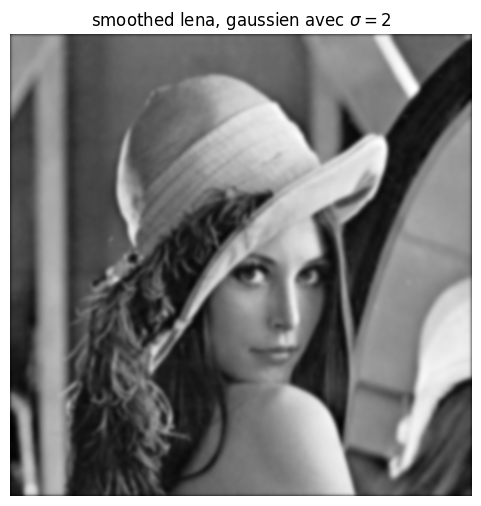

In [9]:
sigma = 2
gauss = gaussianKernel(sigma)
smoothed_lena = convolve2d(lena, gauss, mode='same')
imshow(smoothed_lena, "smoothed lena, gaussien avec $\sigma=2$")

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

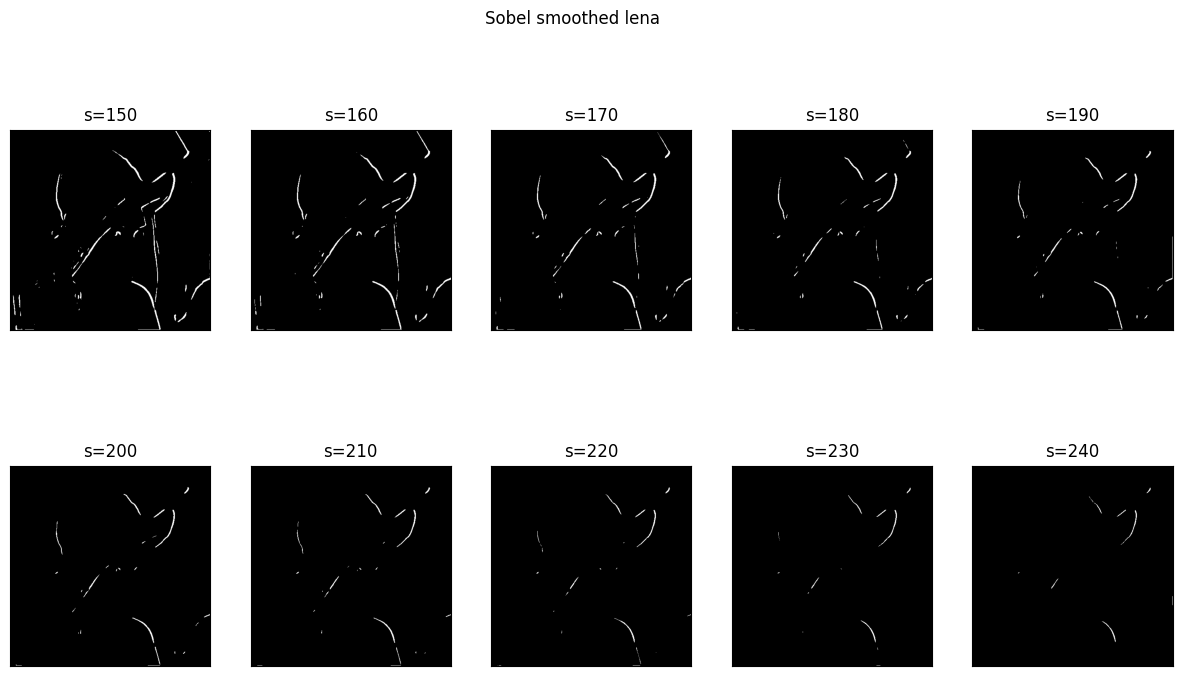

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
fig.suptitle("Sobel smoothed lena")
elems = 0
for s in range(150, 250, 10):
    tmp = SobelDetector(smoothed_lena, s)
    i, j = elems//5, elems-5 if elems >= 5 else elems
    ax[i, j].imshow(tmp, cmap="gray")
    ax[i, j].set_title(f"s={s}")
    ax[i, j].set_xticks(())
    ax[i, j].set_yticks(())
    elems += 1
plt.show()

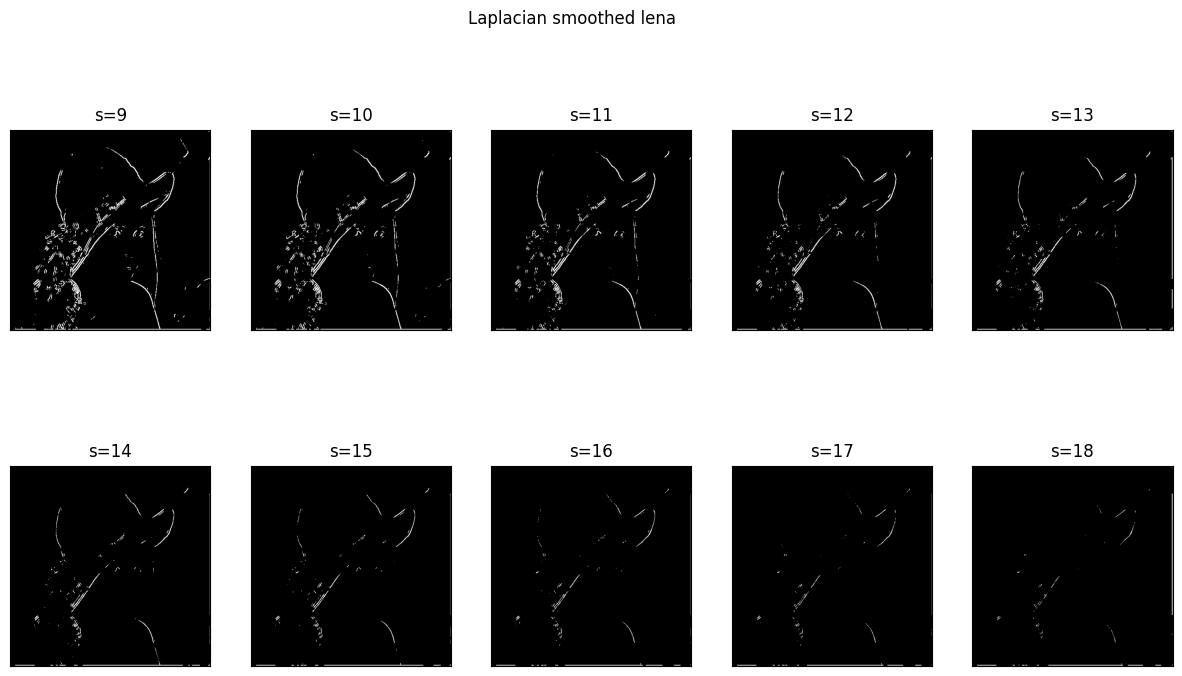

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
fig.suptitle("Laplacian smoothed lena")
elems = 0
for s in range(9, 19):
    tmp = LaplacianDetector(smoothed_lena, s)
    i, j = elems//5, elems-5 if elems >= 5 else elems
    ax[i, j].imshow(tmp, cmap="gray")
    ax[i, j].set_title(f"s={s}")
    ax[i, j].set_xticks(())
    ax[i, j].set_yticks(())
    elems += 1
plt.show()

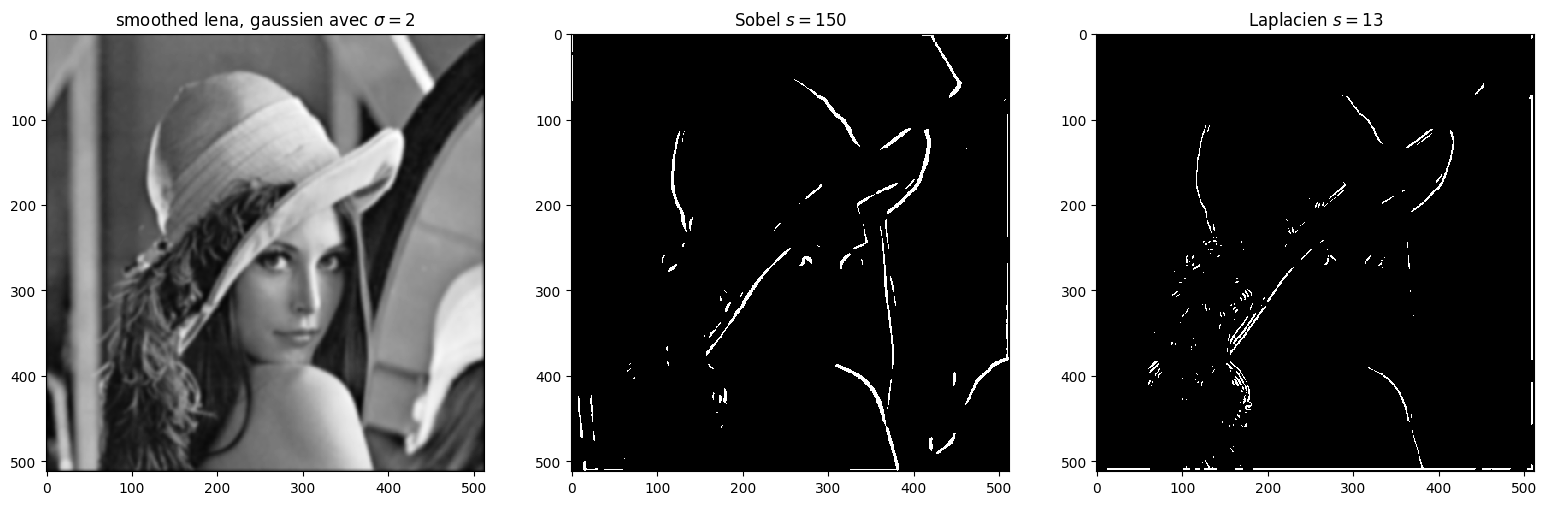

In [12]:
niceDisplay14([smoothed_lena, SobelDetector(smoothed_lena, 150), LaplacianDetector(smoothed_lena, 13)], ["smoothed lena, gaussien avec $\sigma=2$", "Sobel $s=150$", "Laplacien $s=13$"])

Nous constatons que les contours sont plus épais avec Sobel qu'avec Laplacien. Le détecteur Laplacian est moins sensible à la valeur du seuil et conserve plus de détails fins, comme la plume sur le chapeau qui n'est pas autant visible avec Sobel. Cependant, Sobel est moins sensible au bruit, tandis que Laplacien peut encore montrer du bruit même après le lissage.

Les deux détecteurs trouvent approximativement les mêmes contours pour un seuil de Sobel $=150$ et Laplacian $=13$.

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

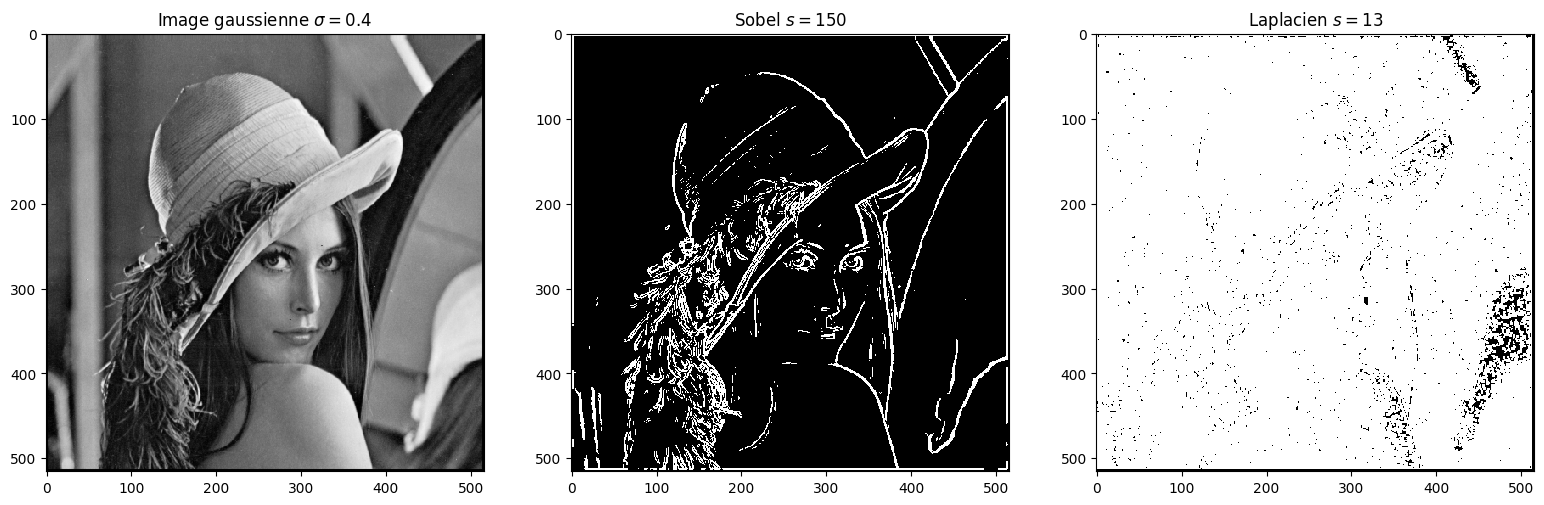

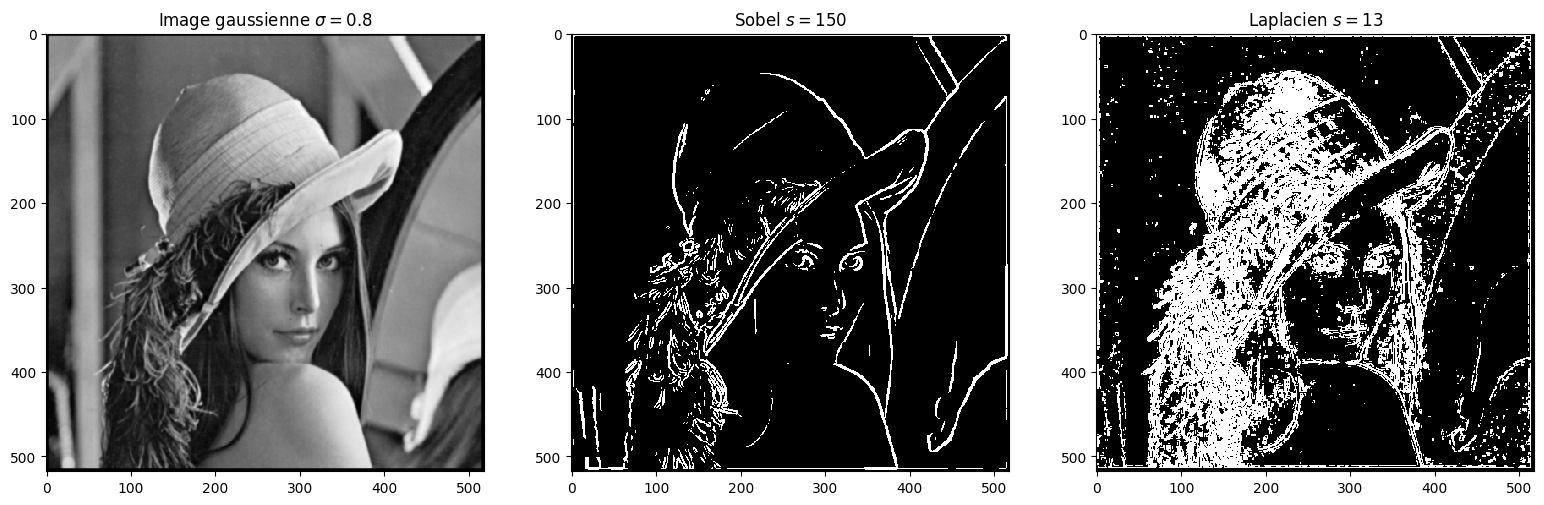

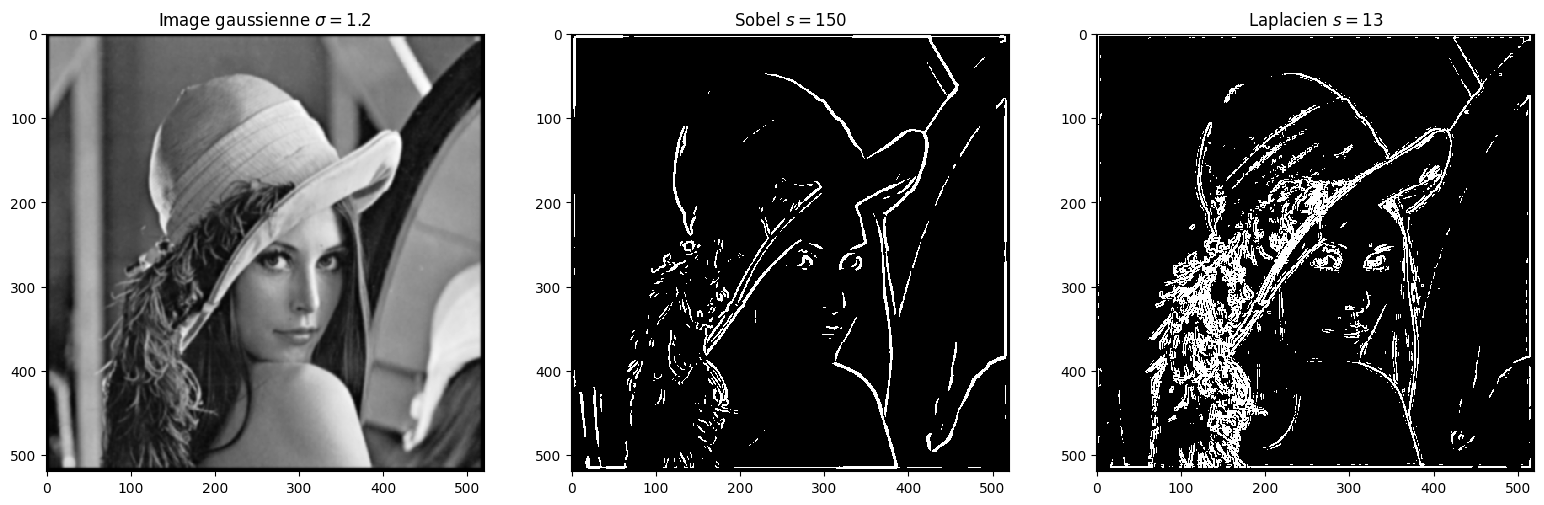

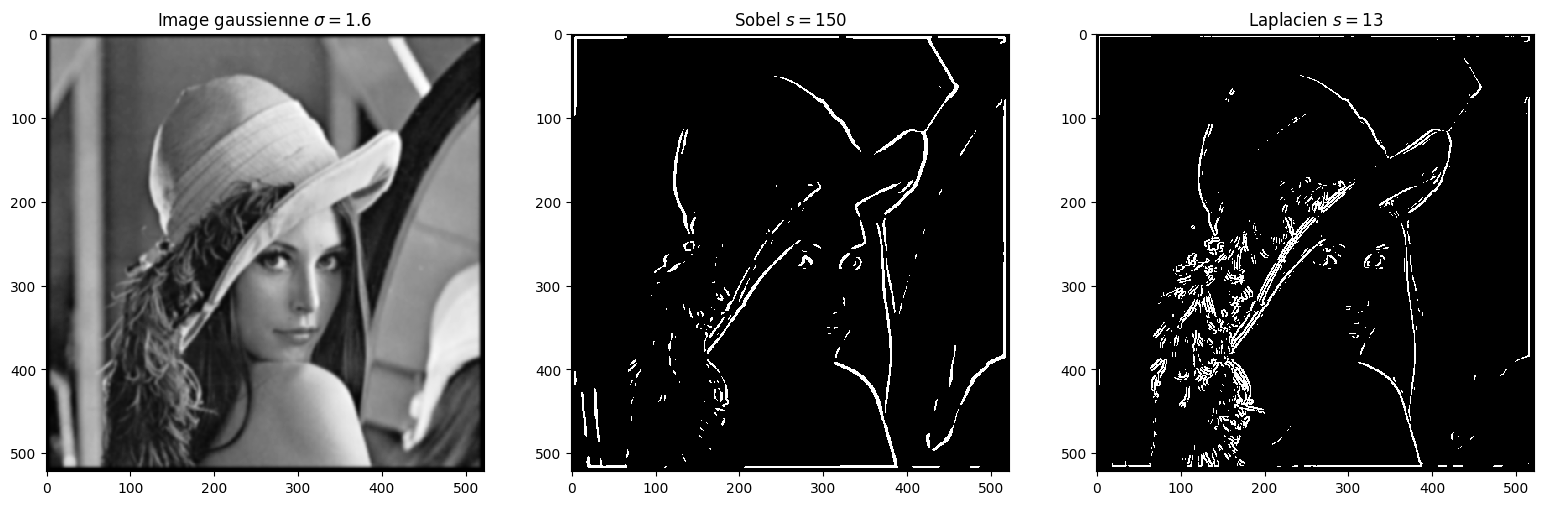

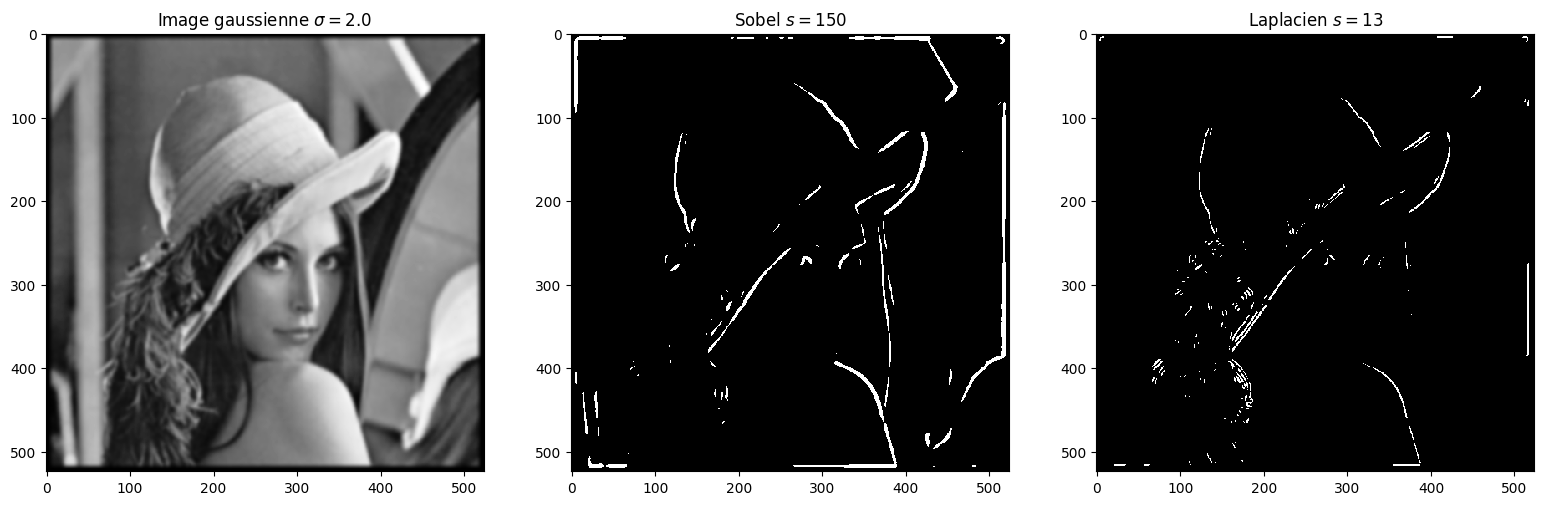

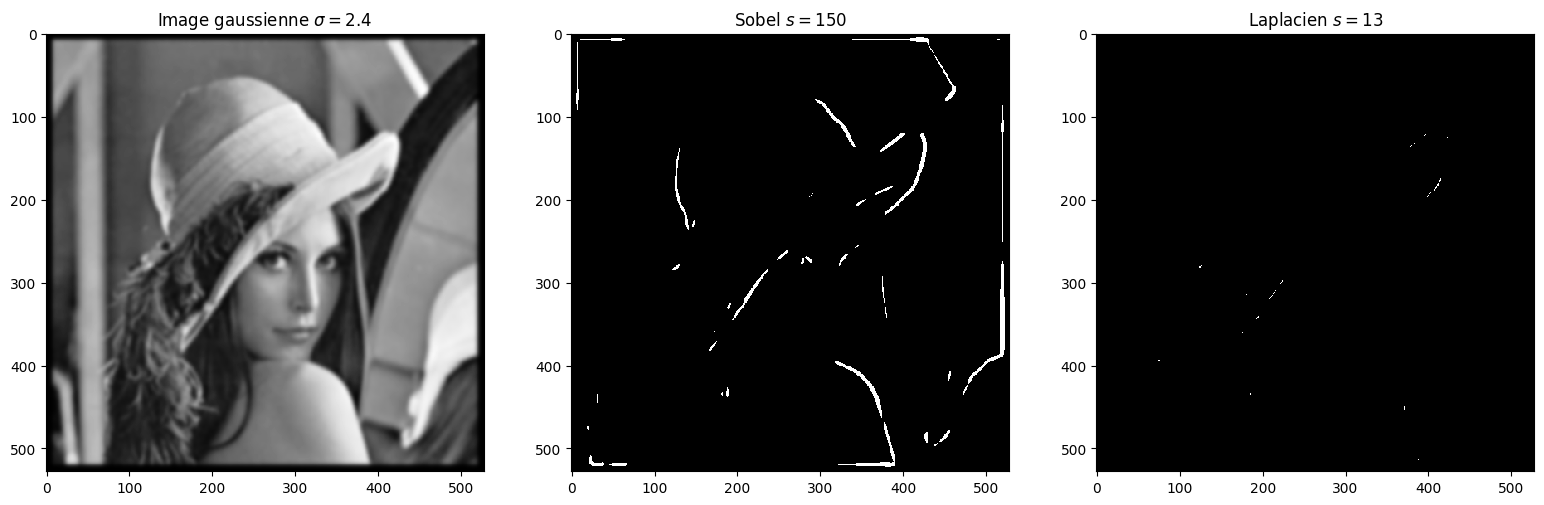

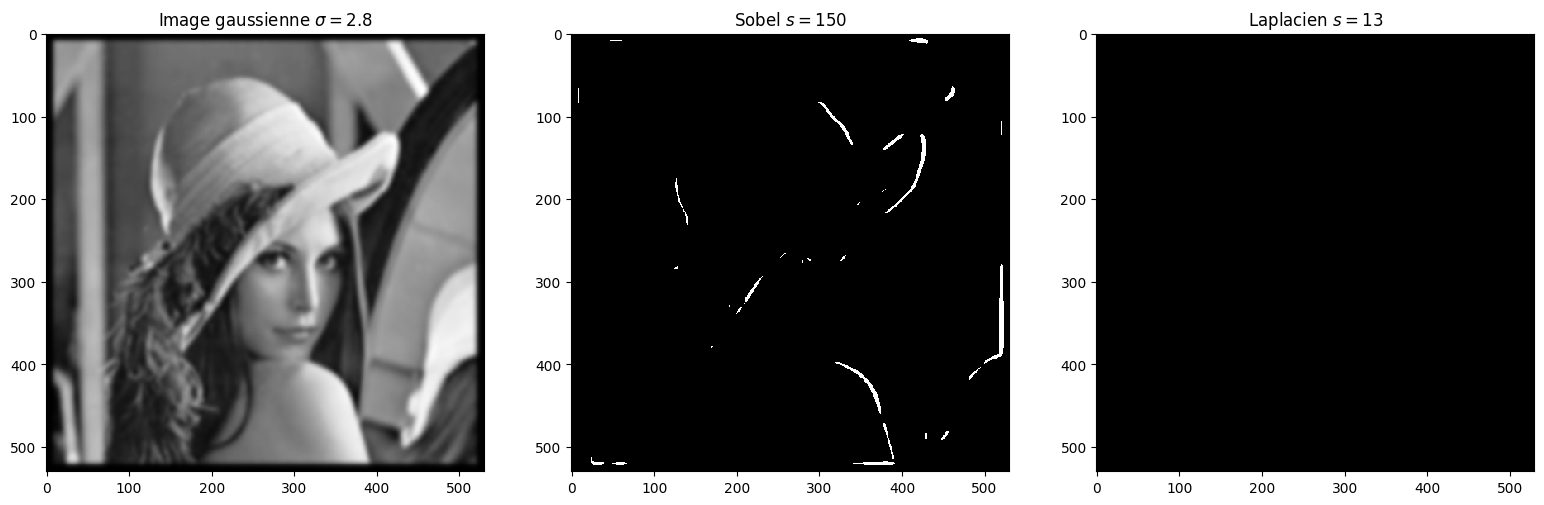

In [13]:
for sigma in np.arange(0.4, 2.9, 0.4):
    gauss_lena = convolve2d(lena, gaussianKernel(sigma))
    niceDisplay14([gauss_lena, SobelDetector(gauss_lena, 150), LaplacianDetector(gauss_lena, 13)], ["Image gaussienne $\sigma=${:.1f}".format(sigma), "Sobel $s=150$", "Laplacien $s=13$"])

On a testé avec des valeurs de $\sigma\in[0.4, 2.8]$.
Comme discuté auparavant, le filtre gaussien réduit le bruit, ce qui permet de détecter des contours plus fins et plus nets. Cependant, des détails dans les contours peuvent être perdus. Si on augmente trop la valeur de sigma du filtre(=image trop lisse), la plupart des contours risquent de ne pas être détectés. Sobel est moins sensible au bruit et conserve mieux les contours principaux après un lissage important, tandis que Laplacien peut perdre des détails fins et être plus affecté par le lissage excessif. On peut notamment observer cet effet pour le cas de $\sigma=2.8$, le laplacien ne détecte aucun contour avec $s=13$ et l'image résultante est toute noire alors que dans le cas de $\sigma=0.4$ le résultat de Laplacien nous donnait une image presque toute blanche avec le même seuil.

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

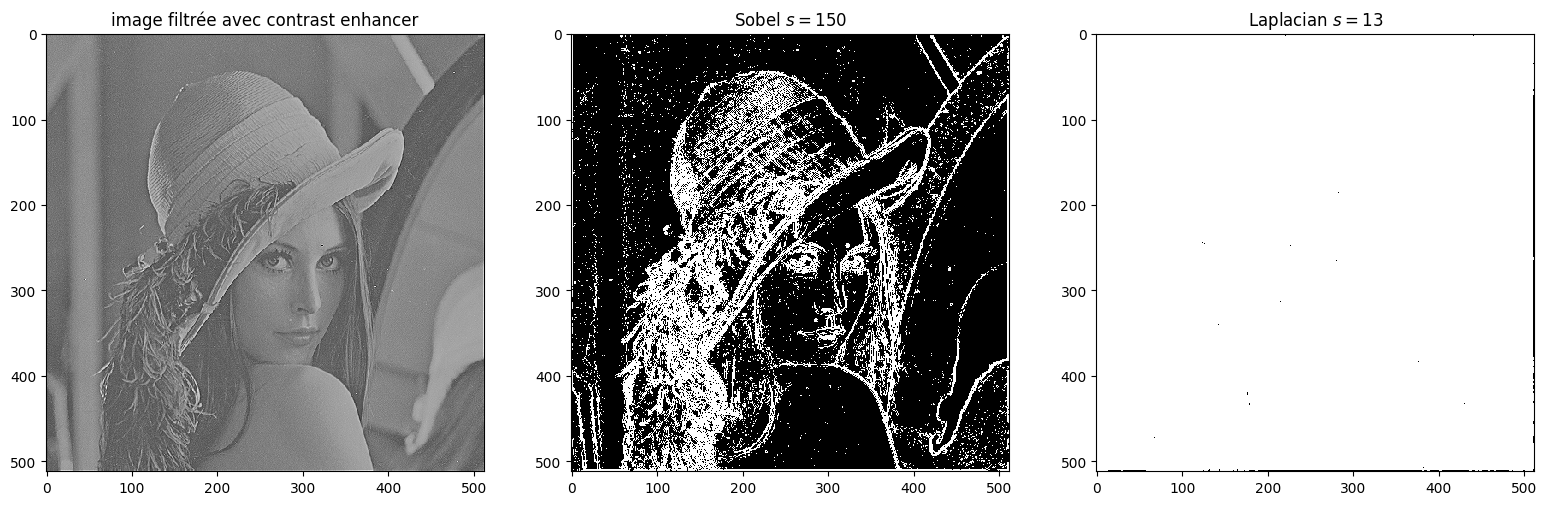

In [14]:
contrast = np.array([[0,-1,0], [-1,5,-1],[0,-1,0]])
contrasted_lena = convolve2d(lena, contrast, mode='same')
niceDisplay14([contrasted_lena, SobelDetector(contrasted_lena,150), LaplacianDetector(contrasted_lena, 13)], ["image filtrée avec contrast enhancer", "Sobel $s=150$", "Laplacian $s=13$"])

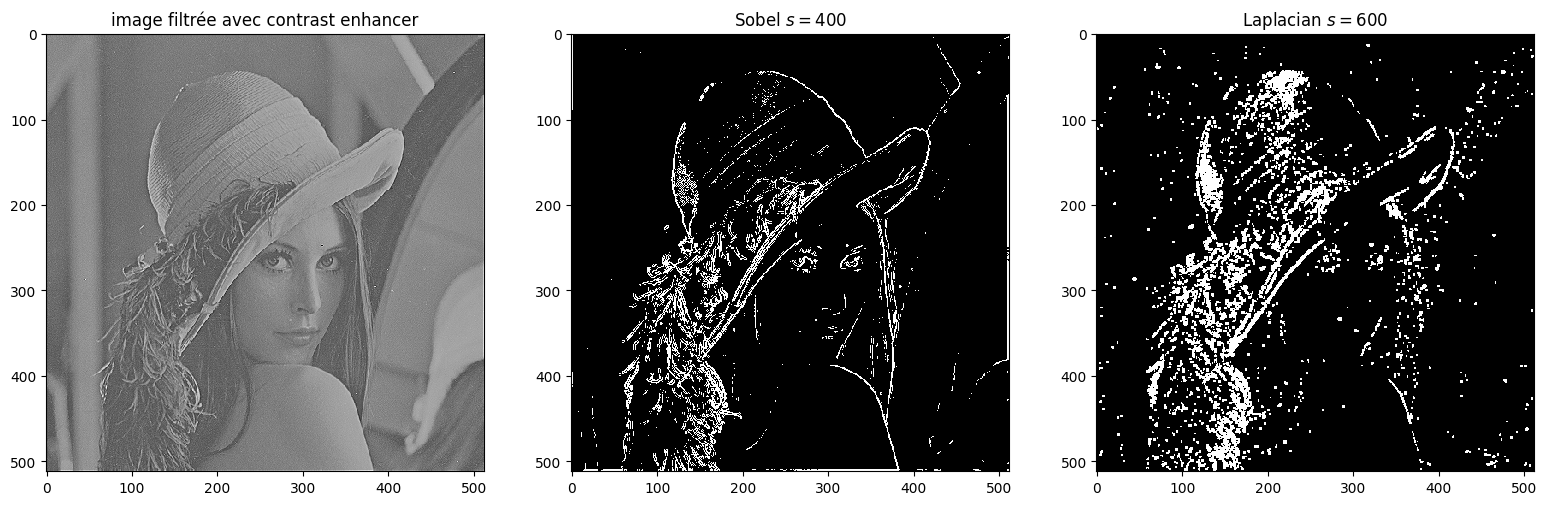

In [15]:
contrast = np.array([[0,-1,0], [-1,5,-1],[0,-1,0]])
contrasted_lena = convolve2d(lena, contrast, mode='same')
niceDisplay14([contrasted_lena, SobelDetector(contrasted_lena,400), LaplacianDetector(contrasted_lena, 600)], ["image filtrée avec contrast enhancer", "Sobel $s=400$", "Laplacian $s=600$"])

En augmentant le contraste nous augmentons les valeurs des pixels ce qui rend les contours plus nets et plus sombres, ce qui facilite leur détection. Cependant, en faisant cela nous amplifions également le bruit. Le seuil de Laplacien doit être beaucoup plus élevé afin que l'on puisse bien distinguer les contours. Pour un seuil inférieur à $100$, l'image résultante est complètement blanche. Nous avons besoin d'une augmentation de seuil pour Sobel aussi mais celle-ci est moins importante que pour le Laplacien.

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

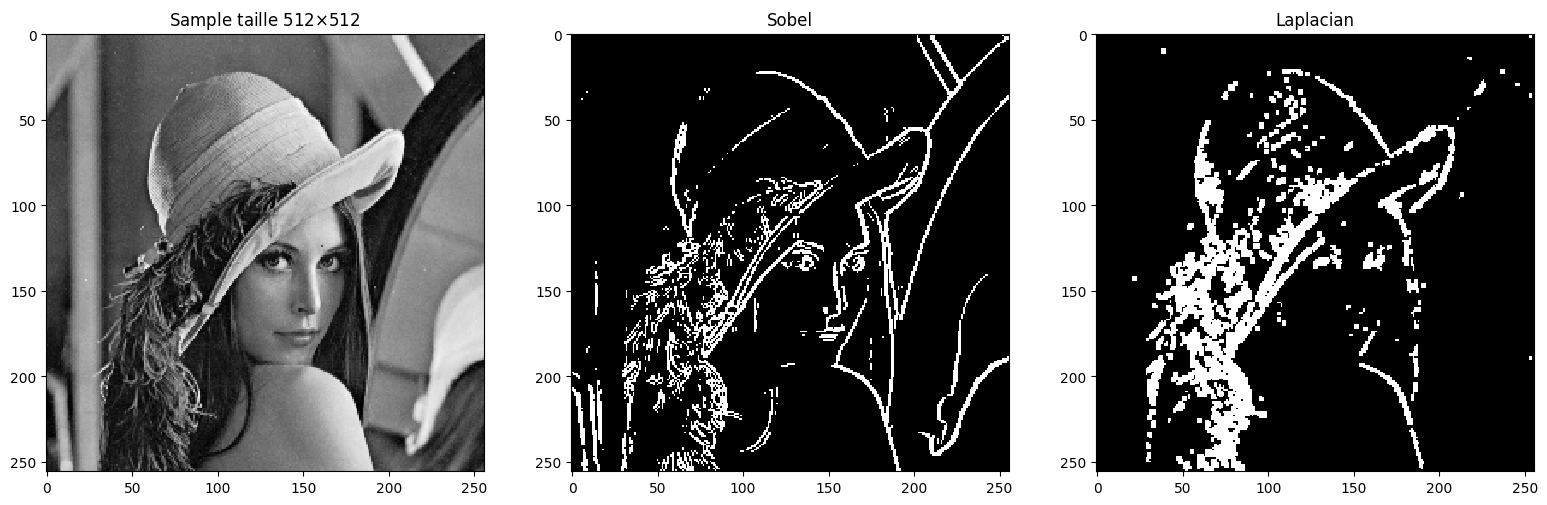

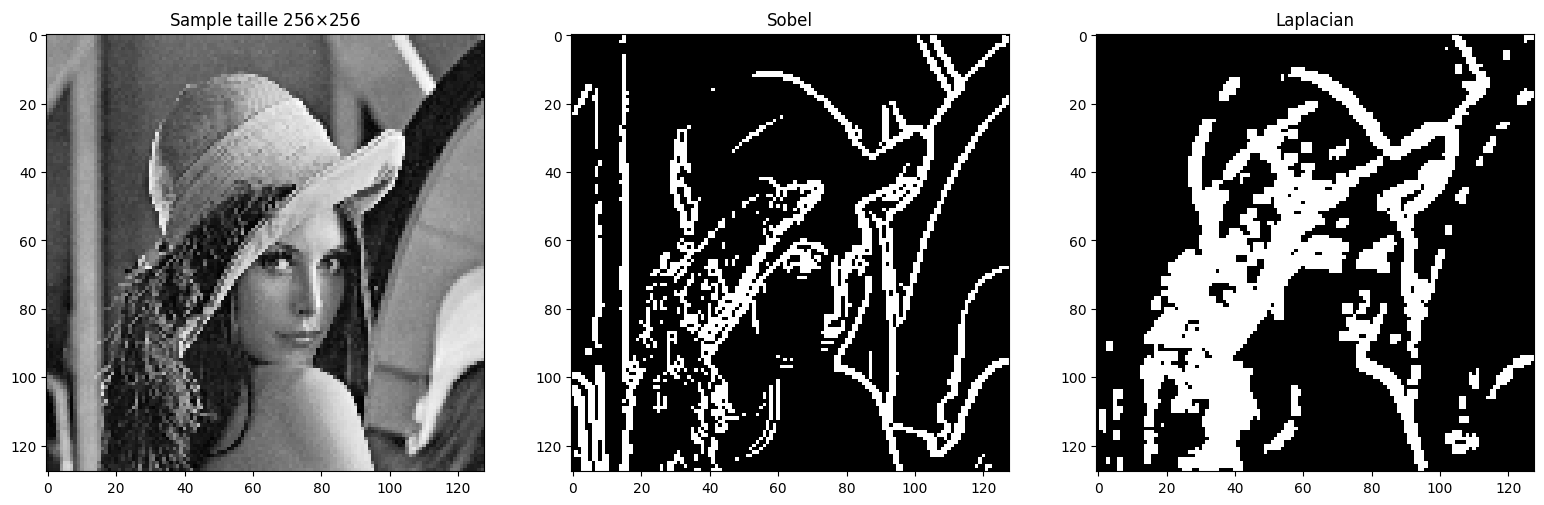

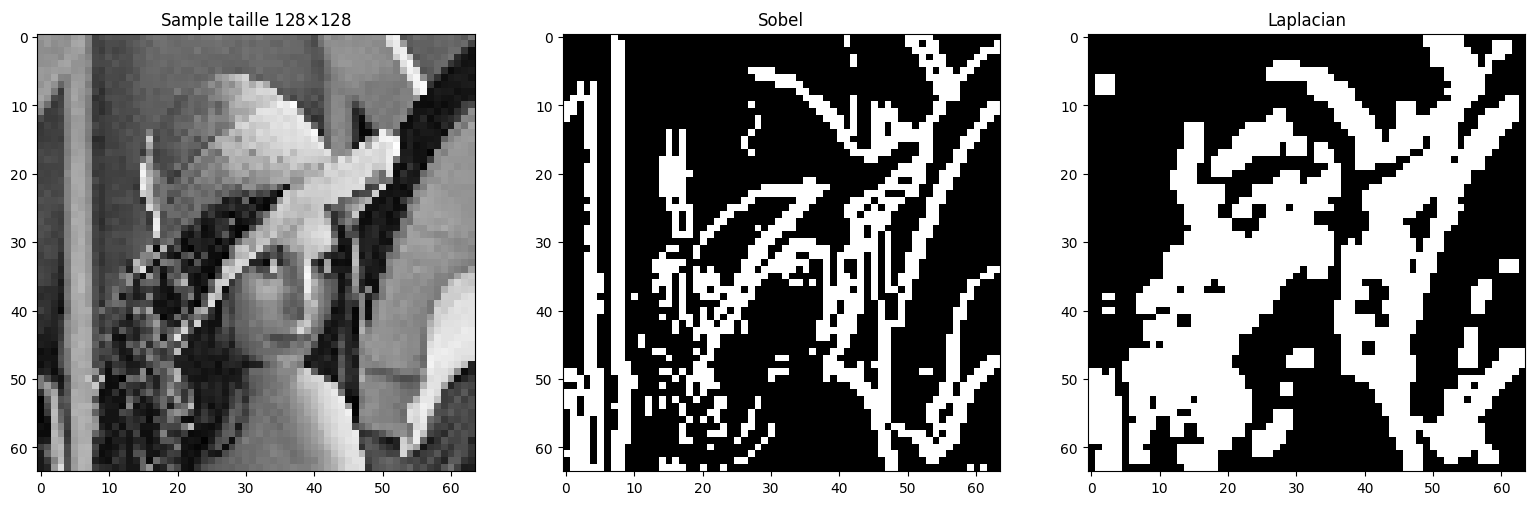

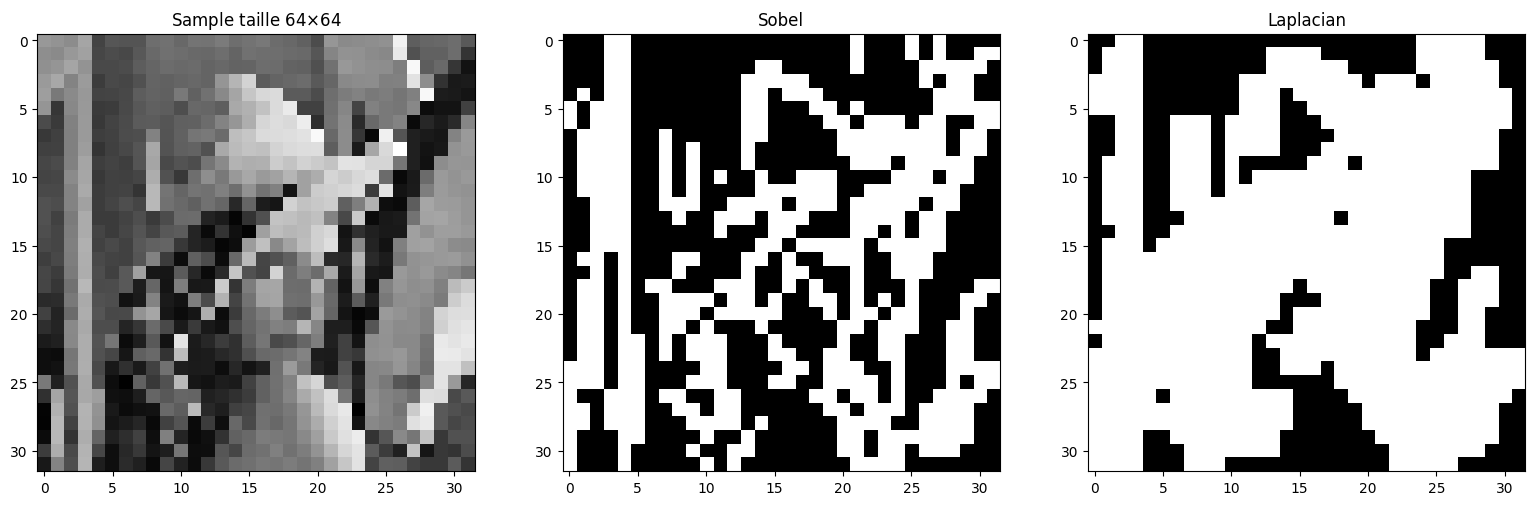

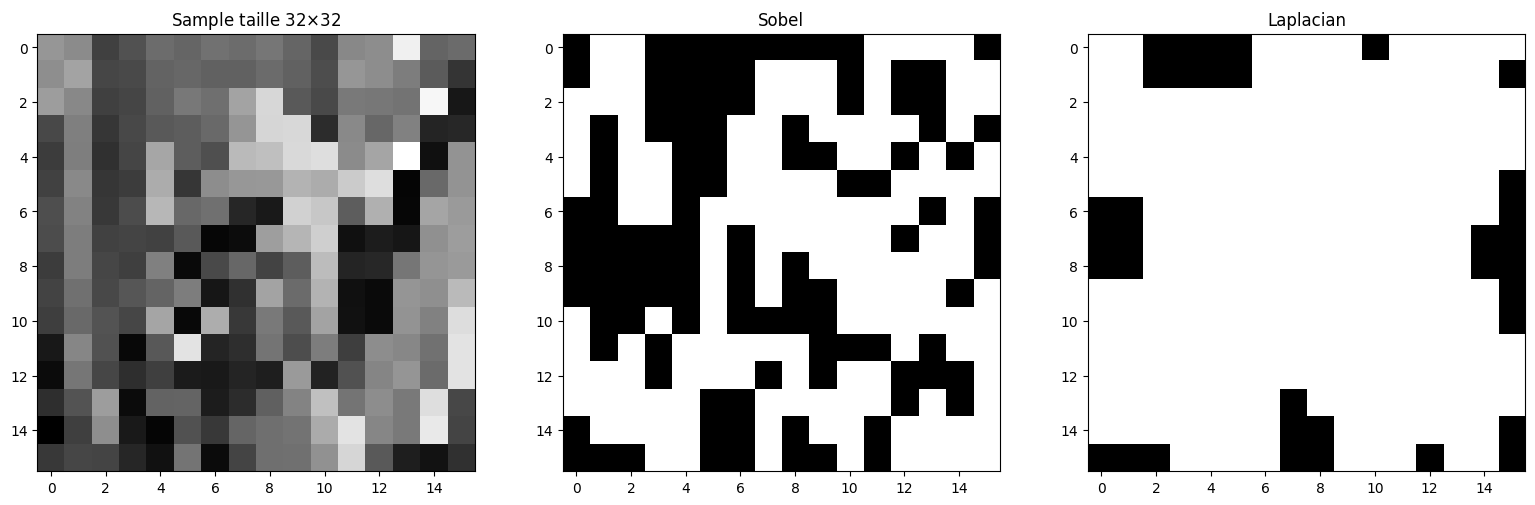

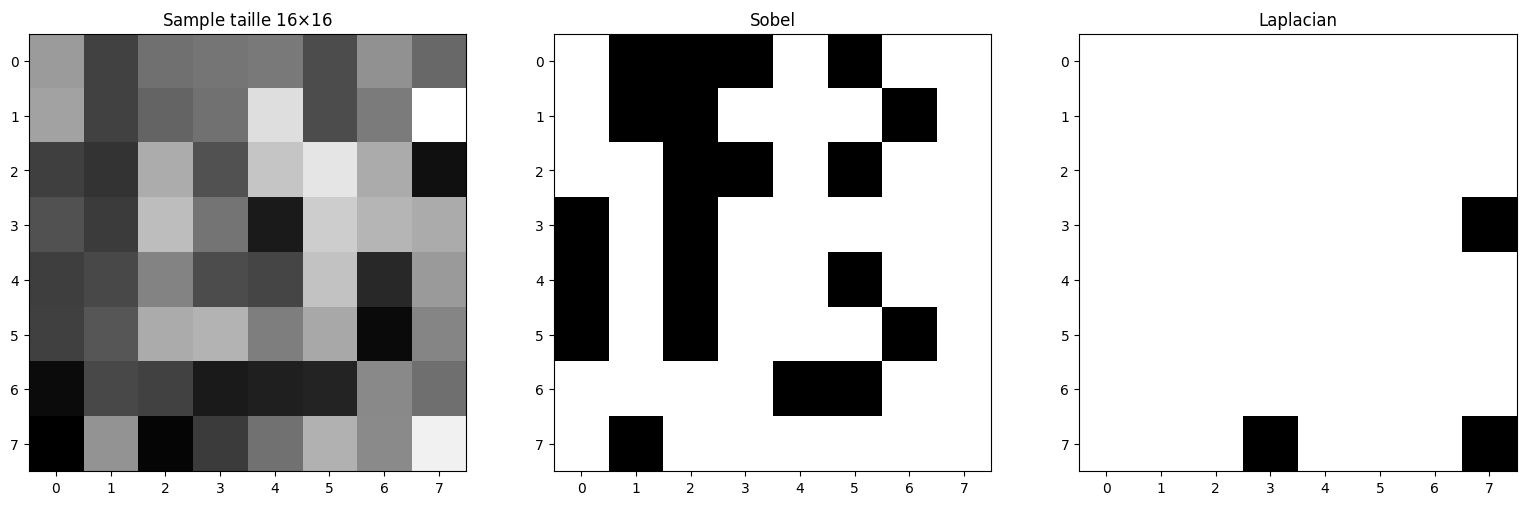

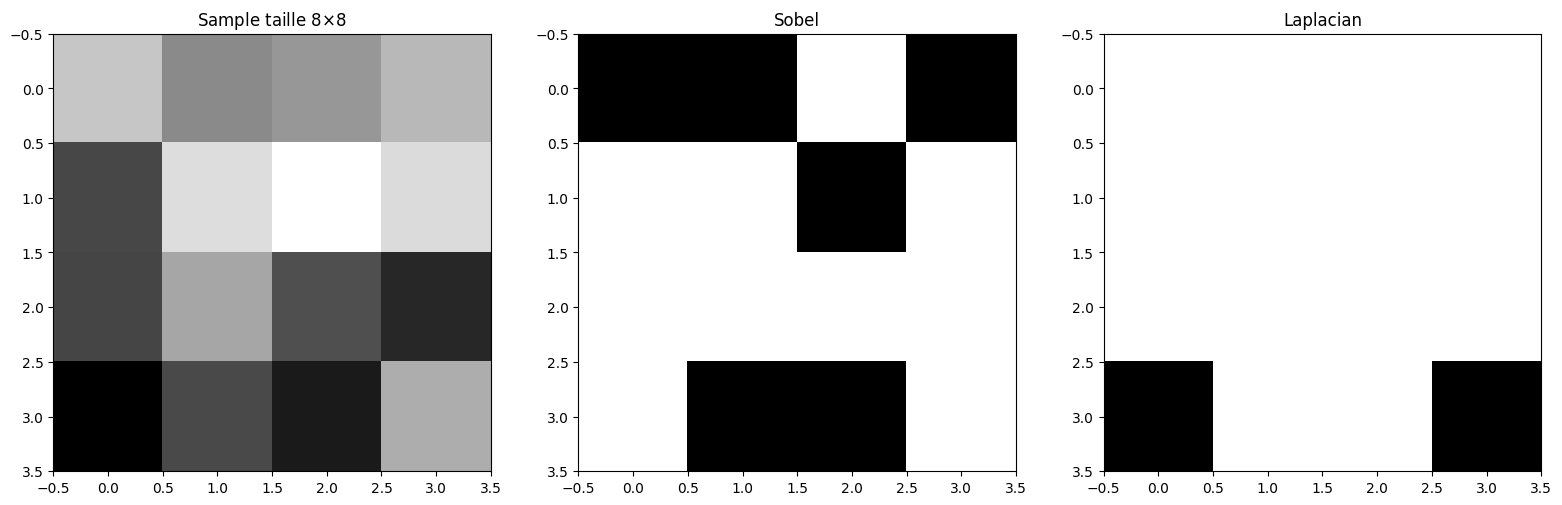

In [16]:
def subSample(I):
    return I[::2,::2]

test = np.copy(lena)
taille = test.shape[0]
while taille>=8:
    test = subSample(test)
    niceDisplay14([test, SobelDetector(test, 200), LaplacianDetector(test, 200)], [f"Sample taille {taille}$\\times${taille}", "Sobel", "Laplacian"])
    taille //= 2

Pour atteindre une taille $8 \times 8$ depuis la taille $512 \times 512$:
$$\frac{512}{x} = 8$$
$$x=64=2^6 $$
C'est-à-dire qu'il faut sous-échantillonner notre image $6$ fois avec un facteur de $2$.

En utilisant la technique du sous-échantillonnage, sans filtrage préalable, on peut introduire de l'aliasing, ce qui ajoute des hautes fréquences indésirables. Plus on l'applique, plus on perd de pixels et de contours, ce qui signifie que nous ne pourrons plus les détecter correctement.

Sobel fonctionne mieux dans ce cas, surtout quand la taille de l'image devient inférieure à $32 \times 32$. Nous pouvons encore voir les contours de Lena avec Sobel à cette taille, ce qui n'est pas le cas avec le Laplacien : il s'agit d'une image blanche avec deux ou trois carrés noirs.